# グラフで2バイト文字を使うためのライブラリのインストール

In [ ]:
!pip install japanize_matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 53.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=0b537cd50513095f177f37bc384ca74a72b7936196b89ab283645676c7170795
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize_matplotlib


# 乱数シードの固定

In [ ]:
import random
import numpy as np
import os

np.random.seed(0)
random.seed(0)
os.environ["PYTHONHASHSEED"] = str(0)

# 関数 save_fig：図の保存用

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

def save_fig(plt, file_prefix):
    if file_prefix == '':
        return

    parent = os.path.dirname(os.path.abspath(file_prefix))
    os.makedirs(parent, exist_ok=True)
    plt.savefig(f'{file_prefix}.pdf', transparent=True, bbox_inches='tight', pad_inches = 0.2)
    plt.savefig(f'{file_prefix}.png', transparent=True, dpi=300, bbox_inches='tight', pad_inches = 0.2)

# 関数 show_prediction：予測結果の可視化

In [ ]:
def show_prediction(x, y_true, y_pred, ids, dataset='mnist', labels=None, file_prefix=''):
    '''認識結果を可視化する。
    Args:
        x (ndarray): 画像。形状は(B, N)。Bは画像枚数、Nは1枚の画像の画素数
        y_true (ndarray): 正解クラスラベル。形状は(B, C)。Bは画像枚数、Cはクラス数
        y_pred (ndarray): 予測クラスラベル。形状は(B, C)。Bは画像枚数、Cはクラス数
        ids (ndarray): 表示する画像のインデックスを格納した配列
        dataset (str): データセット名
        labels (list): クラスラベル名が格納されたリスト
        file_prefix (str): 可視化結果を保存する際のファイル名接頭辞
    '''

    def _mnist():
        """MNIST用可視化関数"""
        img = x[ids].reshape((len(ids), 28, 28))

        labels = y_true[ids]
        preds = y_pred[ids]

        # AIが認識した結果を画像と一緒に提示する
        plt.figure(2, figsize=(12, 8))
        plt.gray()
        for i in range(len(ids)):
            plt.subplot(8, 12, i + 1)
            plt.pcolor(img[i])
            plt.text(22, 25.5, "%d" % preds[i], fontsize=12, color='yellow')
            if preds[i] != labels[i]:
                plt.plot([0, 27], [1, 1], color='red', linewidth=5)

            plt.xlim(0, 27)
            plt.ylim(27, 0)
            plt.xticks([], '')
            plt.yticks([], '')

        plt.tight_layout()
        save_fig(plt, file_prefix=file_prefix)
        plt.show()

    def _cifar10():
        """CIFAR-10用可視化関数"""
        img = x[ids].reshape((len(ids), 32, 32, 3))

        trues = y_true[ids]
        preds = y_pred[ids]

        # AIが認識した結果を画像と一緒に提示する
        plt.figure(figsize=(24, 16))
        for i in range(len(ids)):
            plt.subplot(8, 12, i + 1)
            plt.imshow(img[i])

            p = preds[i]
            t = trues[i]
            if p != t:
                plt.title(f'{labels[t]}({labels[p]})', color='red', fontsize=12)
            else:
                plt.title(f'{labels[t]}', fontsize=12)

            plt.axis('off')

        plt.tight_layout()
        save_fig(plt, file_prefix=file_prefix)
        plt.show()

    if dataset == 'mnist':
        _mnist()
    else:
        _cifar10()

# 関数 evaluate：性能評価関数

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import seaborn as sns

def evaluate(x, y_true, y_pred, file_prefix=''):
    """予測結果に対する性能評価を行う。正解率、精度、再現率の計算。混同行列をヒートマップとして可視化。
    Args:
        x (ndarray): 画像。形状は(B, N)。Bは画像枚数、Nは1枚の画像の画素数
        y_true (ndarray): 正解クラスラベル。形状は(B, C)。Bは画像枚数、Cはクラス数
        y_pred (ndarray): 予測クラスラベル。形状は(B, C)。Bは画像枚数、Cはクラス数
        file_prefix (str): 可視化結果を保存する際のファイル名接頭辞
    """
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    print('正解率')
    print(f' {accuracy:.2f}')

    class_labels = []

    num_classes = np.max(y_true) + 1
    for i in range(num_classes):
        class_labels.append(f'{i:4d}')

    precision_str = []
    recall_str = []
    for i in range(num_classes):
        precision_str.append(f'{precision[i]:.2f}')
        recall_str.append(f'{recall[i]:.2f}')

    print('精度')
    print(' ' + ' '.join(class_labels))
    print(' ' + ' '.join(precision_str))

    print('再現率')
    print(' ' + ' '.join(class_labels))
    print(' ' + ' '.join(recall_str))

    plt.figure(figsize = (10,7))
    sns.heatmap(cm, annot=True, fmt='3d', square=True, cmap='hot')
    plt.tight_layout()
    save_fig(plt, file_prefix=file_prefix)
    plt.show()

# 関数 show_history：学習過程の可視化

In [ ]:
def show_history(history, file_prefix=''):
    """学習過程（損失と正解率）を可視化する
    Args:
        history (tf.keras.callbacks.History): 損失やモニターする指標を格納したオブジェクト
    """
    plt.figure(figsize=(16, 8))
    plt.subplots_adjust(wspace=0.2)

    # 学習曲線の表示
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], 'black', label='Training')
    plt.plot(history.history['val_loss'], 'cornflowerblue', label='Test')
    plt.legend(fontsize=16)
    plt.xlabel('エポック', fontsize=16)
    plt.title('損失', fontsize=16)
    plt.ylim(0, )
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)

    # 正解率表示
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], 'black', label='Training')
    plt.plot(history.history['val_accuracy'], 'cornflowerblue', label='Test')
    plt.legend(fontsize=16)
    plt.xlabel('エポック', fontsize=16)
    plt.title('正解率', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylim(0, 1.2)
    plt.grid(True)

    save_fig(plt, file_prefix)

    plt.show()

# 関数 load_cifar10：CIFAR-10データセットの準備

In [ ]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import numpy as np

# ラベル名
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def load_cifar10():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    ny, nx, nc = x_train[0].shape
    print('画像の縦方向画素数:', ny)
    print('画像の横方向画素数:', nx)
    print('画像のチャネル数:', nc)

    x_train = x_train.astype('float32')   # 要素値の型をfloat32へ変更
    # 画素値の最大値255を使い、画像の値を0以上1以下の範囲にする（正規化）
    x_train = x_train / 255

    # クラス数。10クラス
    num_classes = np.max(y_train) + 1

    # クラスラベルをone-hotベクトル化
    y_train = to_categorical(y_train, num_classes)
    print('訓練データのクラスラベルの形状:', y_train.shape)

    # テストデータの準備
    x_test = x_test.astype('float32')  # 要素値の型をfloat32へ変更
    # 画素値の最大値255を使い、画像の値を0以上1以下の範囲にする（正規化）
    x_test = x_test / 255

    # クラスラベルをone-hotベクトル化
    y_test = to_categorical(y_test, num_classes)
    print('テストデータのクラスラベルの形状:', y_test.shape)

    return x_train, y_train, x_test, y_test, num_classes

# 実習11.1：ドロップアウトとSGDを使用するCNNの定義

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

# 訓練データ画像、訓練データラベル、テストデータ画像、テストデータラベル、クラス数
x_train,y_train,x_test,y_test,num_classes=load_cifar10()

# 縦、横方向画素数、チャネル数を1枚目の画像から取得
ny,nx,nch = x_train[0].shape

# ネットワークのパラメータ（重みとバイアス）を初期化する際の乱数シードを固定
tf.random.set_seed(0)

# ネットワークモデルを生成。層（レイヤー）の容器と考える。
model1=Sequential()

# 畳み込み層を追加
# 1番目の中間層（畳み込み層）では、入力層の形状を指定する必要がある。
model1.add(Conv2D(input_shape=(ny,nx,nch),  # 入力層の形状
                  filters=16,               # フィルタ数
                  kernel_size=(3,3),        # カーネルサイズ(縦、横)
                  activation='relu'))       # 活性化関数ReLU

# 2番目の中間層:畳み込み層
model1.add(Conv2D(filters=32,               # フィルタ数
                  kernel_size=(3,3),        # カーネルサイズ(縦、横)
                  activation='relu'))       # 活性化関数ReLU

# 3番目の中間層:マックスプーリング層
model1.add(MaxPooling2D(pool_size=(2,2)))   # プールサイズ(縦、横)

# 4番目の中間層:畳み込み層
model1.add(Conv2D(filters=64,               # フィルタ数
                  kernel_size=(3,3),        # カーネルサイズ(縦、横)
                  activation='relu'))       # 活性化関数ReLU

# 5番目の中間層:マックスプーリング層
model1.add(MaxPooling2D(pool_size=(2,2)))   # プールサイズ(縦、横)

# 特徴マップを全結合層への入力(1次元配列)とするため形状を変形
# (6, 6, 16) -> (6 * 6 * 64)
model1.add(Flatten())

model1.add(Dropout(rate=0.5)) # ドロップアウト。rate=0.5の割合でドロップアウトさせる

# これ以降は分類用の全結合型ニューラルネットワーク
# 6番目の中間層:全結合層
model1.add(Dense(units=128,          # ニューロン数
                 activation='relu')) # 活性化関数ReLU

model1.add(Dropout(rate=0.5)) # ドロップアウト。rate=0.5の割合でドロップアウトさせる

# 出力層:全結合層
model1.add(Dense(units=num_classes,     # ニューロン数
                 activation='softmax')) # 活性化関数ソフトマックス関数


model1.compile(optimizer='SGD',                 # パラメータの最適化手法にAdamを指定
               loss='categorical_crossentropy', # 損失関数
               metrics=['accuracy'])            # 損失の他にモニターする指標として正解率を指定

# モデルの要約情報を表示
model1.summary()

170498071/170498071 [==============================] - 6s 0us/step
画像の縦方向画素数: 32
画像の横方向画素数: 32
画像のチャネル数: 3
訓練データのクラスラベルの形状: (50000, 10)
テストデータのクラスラベルの形状: (10000, 10)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                  

# 実習11.2：ドロップアウトとSGDを使用するCNNの学習

In [ ]:
# 学習開始。終了後、学習の履歴がhistory1に代入される
history1=model1.fit(x_train, # 訓練データ：入力画像
                    y_train, # 訓練データ：クラスラベル
                    epochs=500, # エポック数
                    batch_size=1000, # バッチサイズ
                    shuffle=True,    # 学習時にデータの並びをシャッフル
                    validation_data=(x_test,y_test)) # 学習過程での汎化能力の推定のためテストデータを指定

Epoch 1/500
50/50 [==============================] - 13s 48ms/step - loss: 2.3090 - accuracy: 0.1037 - val_loss: 2.2975 - val_accuracy: 0.1377
Epoch 2/500
50/50 [==============================] - 2s 42ms/step - loss: 2.3012 - accuracy: 0.1101 - val_loss: 2.2944 - val_accuracy: 0.1635
Epoch 3/500
50/50 [==============================] - 2s 38ms/step - loss: 2.2973 - accuracy: 0.1173 - val_loss: 2.2914 - val_accuracy: 0.1787
Epoch 4/500
50/50 [==============================] - 2s 39ms/step - loss: 2.2940 - accuracy: 0.1221 - val_loss: 2.2875 - val_accuracy: 0.1895
Epoch 5/500
50/50 [==============================] - 2s 48ms/step - loss: 2.2903 - accuracy: 0.1313 - val_loss: 2.2821 - val_accuracy: 0.1999
Epoch 6/500
50/50 [==============================] - 2s 45ms/step - loss: 2.2845 - accuracy: 0.1384 - val_loss: 2.2737 - val_accuracy: 0.2195
Epoch 7/500
50/50 [==============================] - 2s 43ms/step - loss: 2.2766 - accuracy: 0.1475 - val_loss: 2.2603 - val_accuracy: 0.2184
Epoch

# 実習11.3：ドロップアウトとSGDを使用するCNNの汎化能力

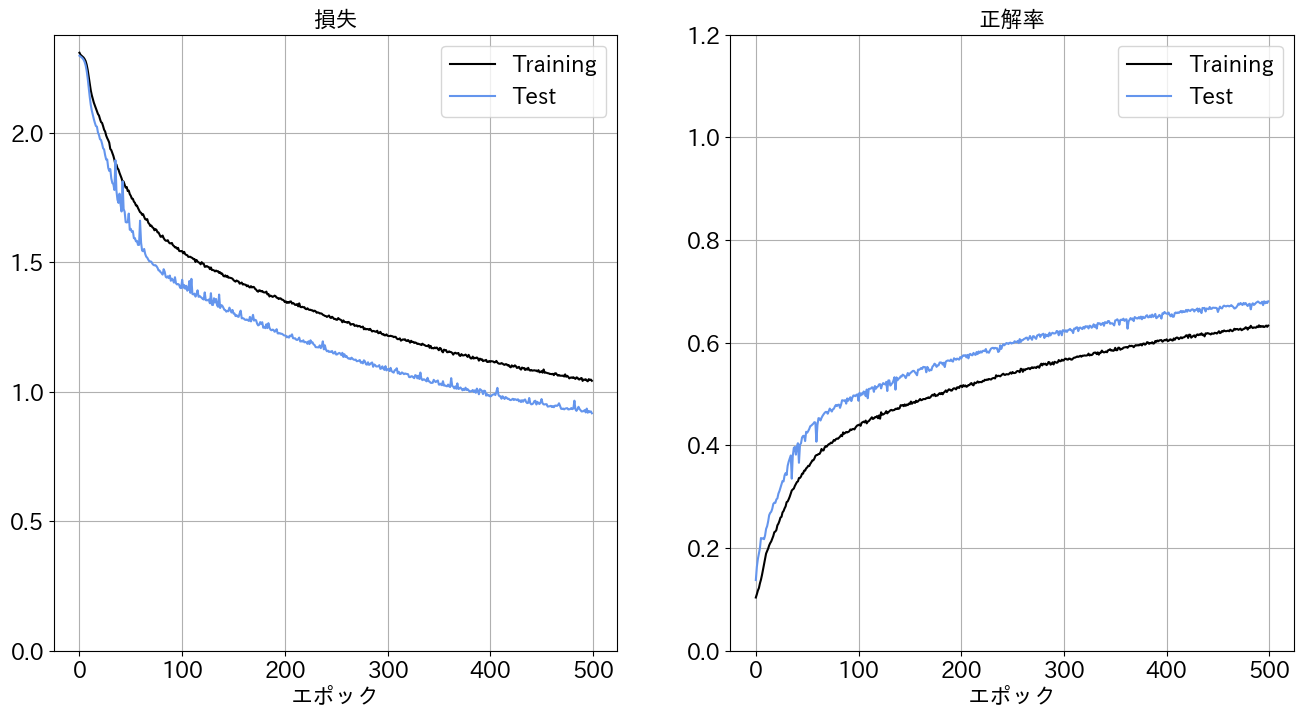

正解率
 0.68
精度
    0    1    2    3    4    5    6    7    8    9
 0.73 0.77 0.58 0.50 0.64 0.57 0.71 0.73 0.79 0.79
再現率
    0    1    2    3    4    5    6    7    8    9
 0.71 0.83 0.54 0.49 0.59 0.58 0.83 0.72 0.79 0.73


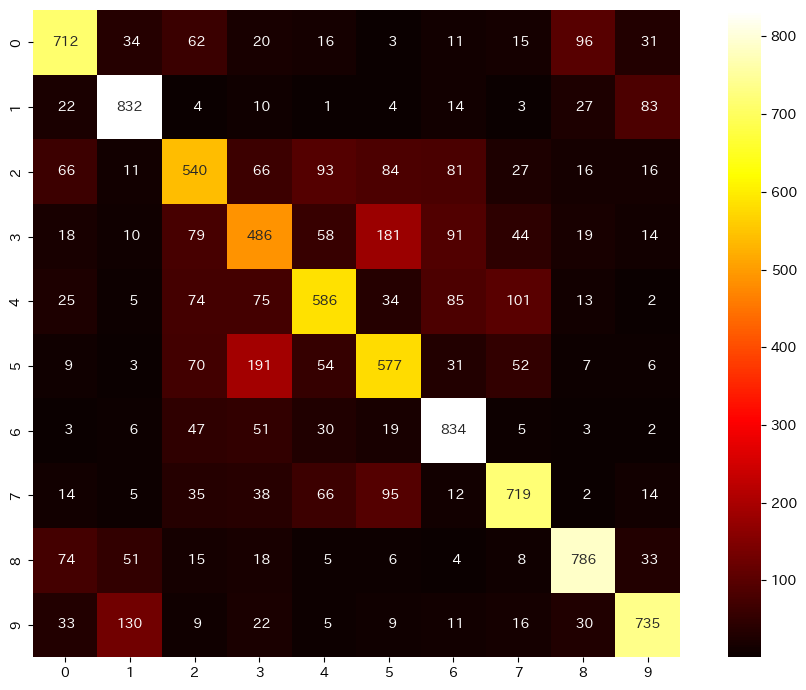

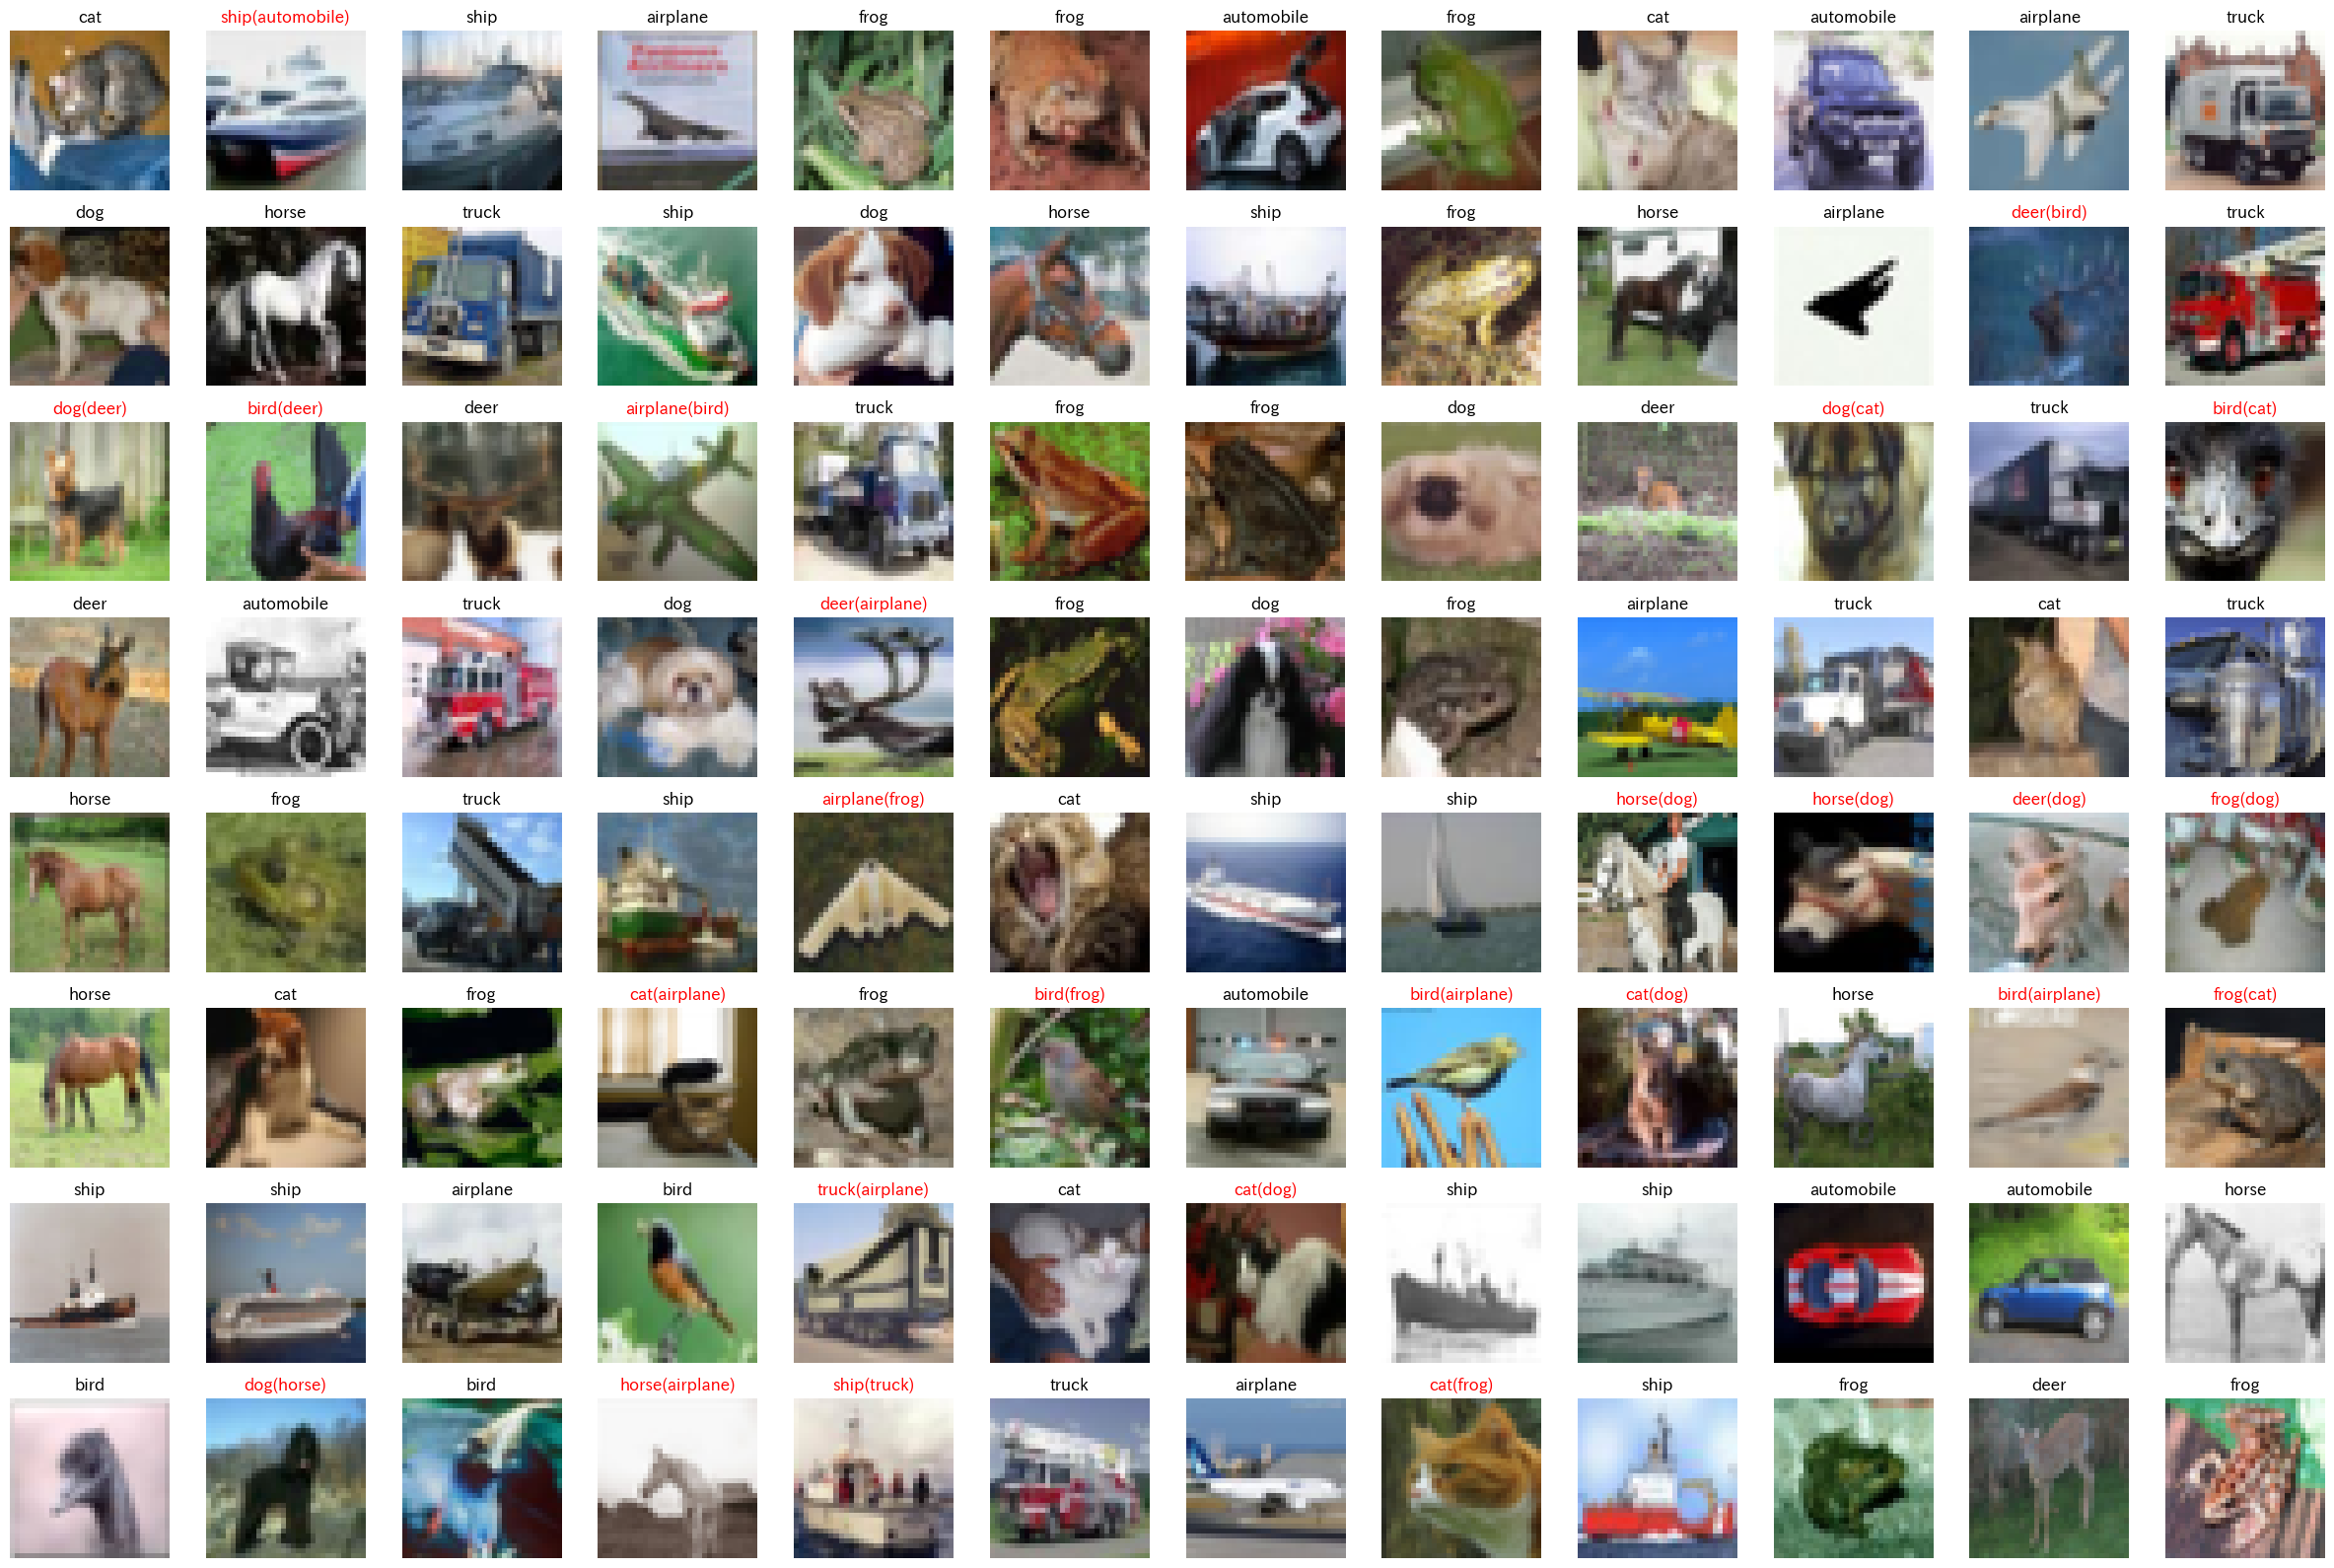

In [ ]:
# 学習の履歴（損失と正解率の変化）を表示
show_history(history1)

# 学習したモデルを使い、テストデータのクラスラベルを予測
y_pred=model1.predict(x_test, verbose=0)

# 各データについて、最大の予測確率を持つクラスラベルを取得
y_pred=np.argmax(y_pred, axis=1)

# 正解（one-hotベクトル）をクラスラベルに戻す
y_true=np.argmax(y_test, axis=1)

# 混同行列、正解率、精度、再現率を評価
evaluate(x_test,y_true,y_pred)

# 予測結果の一部を可視化する
ids=range(96) # 可視化するデータの番号0から95

# データの番号0から95について、予測結果を可視化
show_prediction(x_test,y_true,y_pred,ids, dataset='cifar10',labels=labels)

# 実習11.4：ドロップアウトとRMSpropを使用するCNNの定義

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

# 訓練データ画像、訓練データラベル、テストデータ画像、テストデータラベル、クラス数
x_train,y_train,x_test,y_test,num_classes=load_cifar10()

# 縦、横方向画素数、チャネル数を1枚目の画像から取得
ny,nx,nch = x_train[0].shape

# ネットワークのパラメータ（重みとバイアス）を初期化する際の乱数シードを固定
tf.random.set_seed(0)

# ネットワークモデルを生成。層（レイヤー）の容器と考える。
model2=Sequential()

# 畳み込み層を追加
# 1番目の中間層（畳み込み層）では、入力層の形状を指定する必要がある。
model2.add(Conv2D(input_shape=(ny,nx,nch),  # 入力層の形状
                  filters=16,               # フィルタ数
                  kernel_size=(3,3),        # カーネルサイズ(縦、横)
                  activation='relu'))       # 活性化関数ReLU

# 2番目の中間層:畳み込み層
model2.add(Conv2D(filters=32,               # フィルタ数
                  kernel_size=(3,3),        # カーネルサイズ(縦、横)
                  activation='relu'))       # 活性化関数ReLU

# 3番目の中間層:マックスプーリング層
model2.add(MaxPooling2D(pool_size=(2,2)))   # プールサイズ(縦、横)

# 4番目の中間層:畳み込み層
model2.add(Conv2D(filters=64,               # フィルタ数
                  kernel_size=(3,3),        # カーネルサイズ(縦、横)
                  activation='relu'))       # 活性化関数ReLU

# 5番目の中間層:マックスプーリング層
model2.add(MaxPooling2D(pool_size=(2,2)))   # プールサイズ(縦、横)

# 特徴マップを全結合層への入力(1次元配列)とするため形状を変形
# (6, 6, 16) -> (6 * 6 * 64)
model2.add(Flatten())

model2.add(Dropout(rate=0.5)) # ドロップアウト。rate=0.5の割合でドロップアウトさせる

# これ以降は分類用の全結合型ニューラルネットワーク
# 6番目の中間層:全結合層
model2.add(Dense(units=128,          # ニューロン数
                 activation='relu')) # 活性化関数ReLU

model2.add(Dropout(rate=0.5)) # ドロップアウト。rate=0.5の割合でドロップアウトさせる

# 出力層:全結合層
model2.add(Dense(units=num_classes,     # ニューロン数
                 activation='softmax')) # 活性化関数ソフトマックス関数

model2.compile(optimizer='RMSprop',                  # パラメータの最適化手法にAdamを指定
               loss='categorical_crossentropy', # 損失関数
               metrics=['accuracy'])            # 損失の他にモニターする指標として正解率を指定

# モデルの要約情報を表示
model1.summary()

画像の縦方向画素数: 32
画像の横方向画素数: 32
画像のチャネル数: 3
訓練データのクラスラベルの形状: (50000, 10)
テストデータのクラスラベルの形状: (10000, 10)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                       

# 実習11.5：ドロップアウトとRMSpropを使用するCNNの学習

In [ ]:
# 学習開始。終了後、学習の履歴がhistory2に代入される
history2=model2.fit(x_train, # 訓練データ：入力画像
                    y_train, # 訓練データ：クラスラベル
                    epochs=500, # エポック数
                    batch_size=1000, # バッチサイズ
                    shuffle=True,    # 学習時にデータの並びをシャッフル
                    validation_data=(x_test,y_test)) # 学習過程での汎化能力の推定のためテストデータを指定

Epoch 1/500
50/50 [==============================] - 4s 48ms/step - loss: 2.1264 - accuracy: 0.2189 - val_loss: 1.8265 - val_accuracy: 0.3798
Epoch 2/500
50/50 [==============================] - 2s 36ms/step - loss: 1.8595 - accuracy: 0.3381 - val_loss: 1.6025 - val_accuracy: 0.4382
Epoch 3/500
50/50 [==============================] - 2s 33ms/step - loss: 1.7327 - accuracy: 0.3810 - val_loss: 1.5796 - val_accuracy: 0.4568
Epoch 4/500
50/50 [==============================] - 2s 33ms/step - loss: 1.6338 - accuracy: 0.4169 - val_loss: 1.4886 - val_accuracy: 0.4857
Epoch 5/500
50/50 [==============================] - 2s 34ms/step - loss: 1.5660 - accuracy: 0.4432 - val_loss: 1.4503 - val_accuracy: 0.4960
Epoch 6/500
50/50 [==============================] - 2s 37ms/step - loss: 1.5143 - accuracy: 0.4617 - val_loss: 1.3501 - val_accuracy: 0.5304
Epoch 7/500
50/50 [==============================] - 2s 36ms/step - loss: 1.4583 - accuracy: 0.4855 - val_loss: 1.3220 - val_accuracy: 0.5241
Epoch 

# 実習11.6：ドロップアウトとRMSpropを使用するCNNの汎化性能

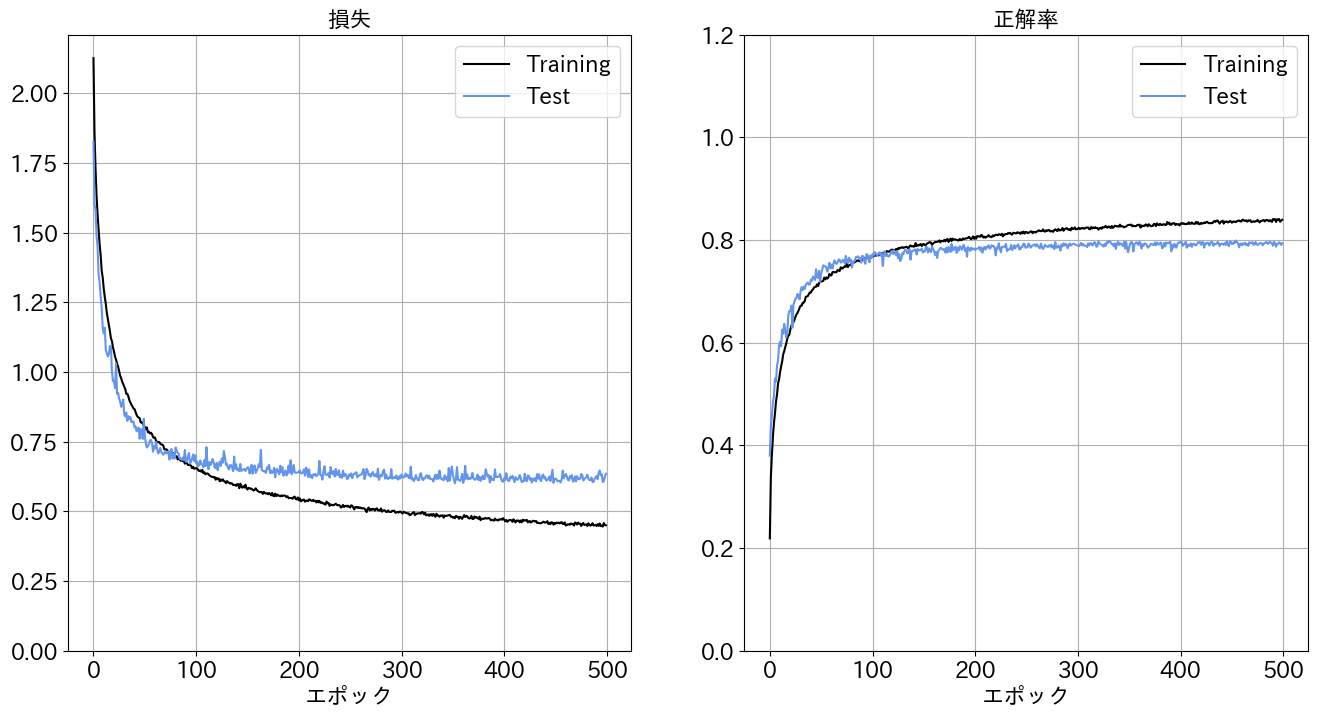

正解率
 0.79
精度
    0    1    2    3    4    5    6    7    8    9
 0.80 0.92 0.76 0.67 0.68 0.78 0.76 0.81 0.88 0.87
再現率
    0    1    2    3    4    5    6    7    8    9
 0.83 0.89 0.63 0.55 0.85 0.65 0.89 0.85 0.90 0.89


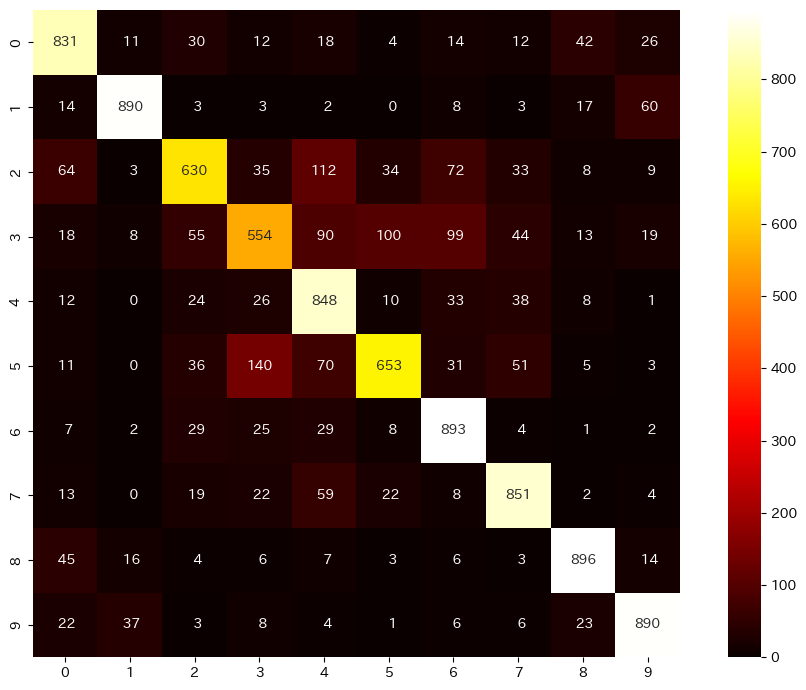

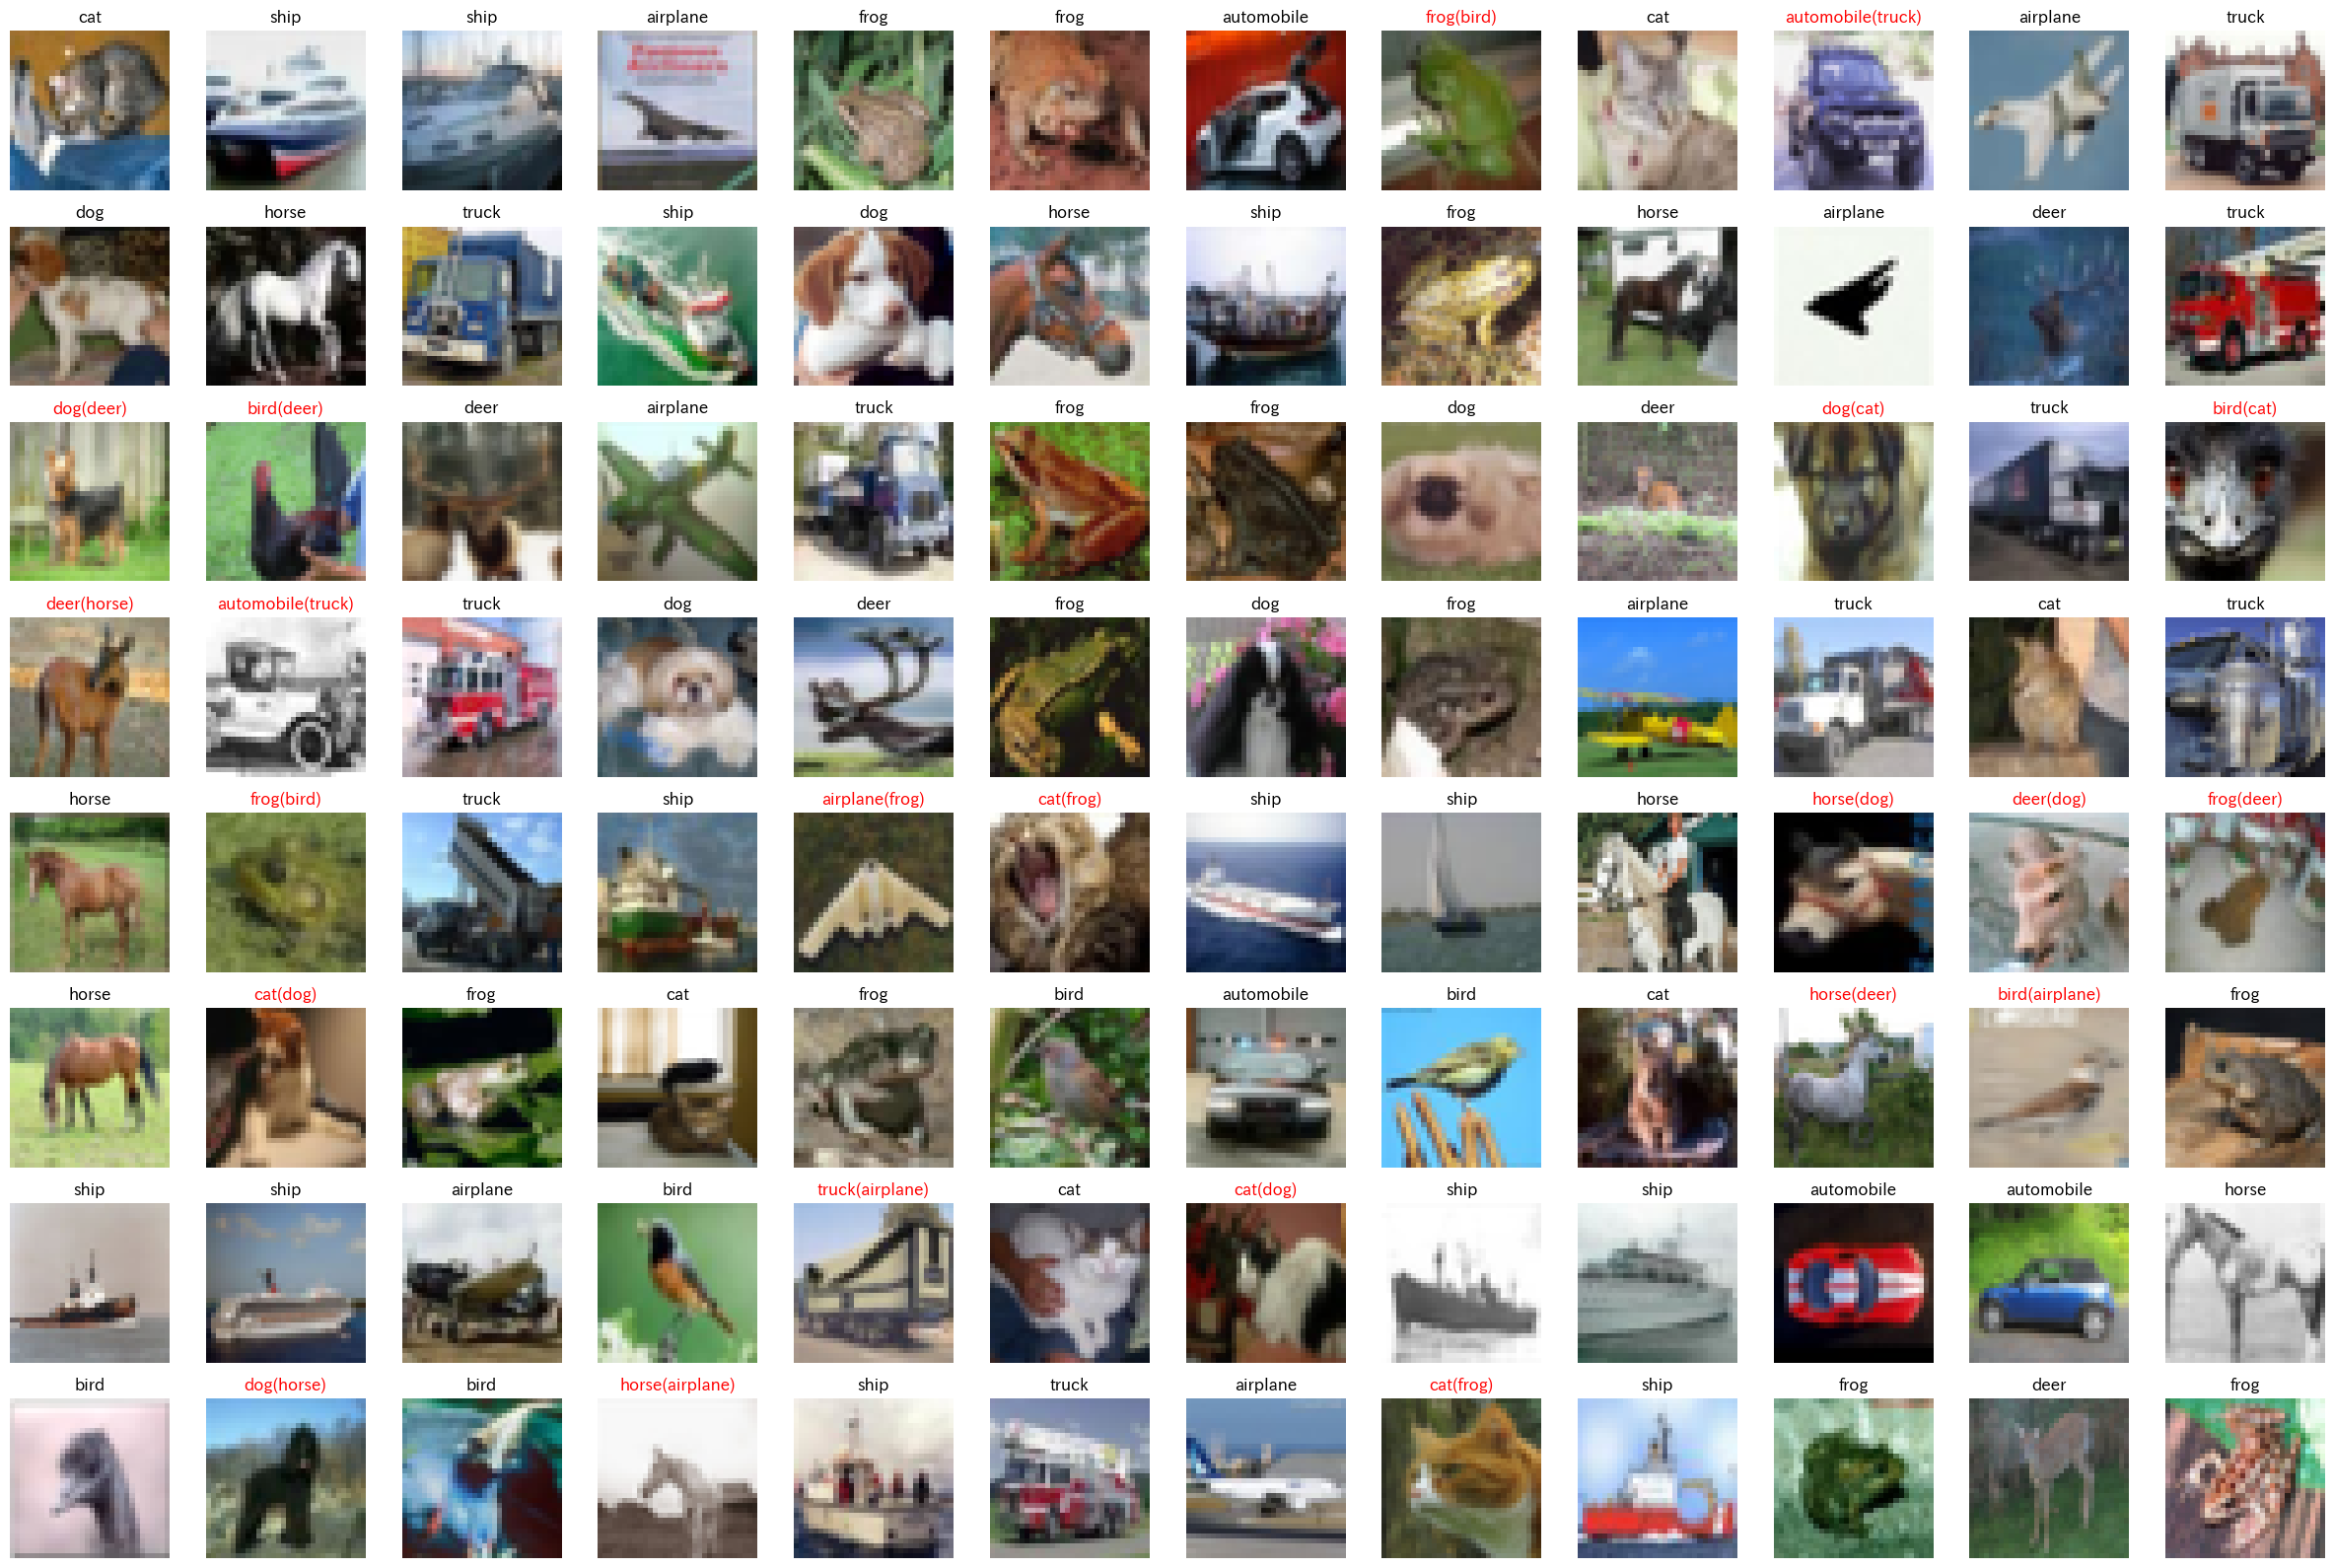

In [ ]:
# 学習の履歴（損失と正解率の変化）を表示
show_history(history2)

# 学習したモデルを使い、テストデータのクラスラベルを予測
y_pred=model2.predict(x_test, verbose=0)

# 各データについて、最大の予測確率を持つクラスラベルを取得
y_pred=np.argmax(y_pred, axis=1)

# 正解（one-hotベクトル）をクラスラベルに戻す
y_true=np.argmax(y_test, axis=1)

# 混同行列、正解率、精度、再現率を評価
evaluate(x_test,y_true,y_pred)

# 予測結果の一部を可視化する
ids=range(96) # 可視化するデータの番号0から95

# データの番号0から95について、予測結果を可視化
show_prediction(x_test,y_true,y_pred,ids, dataset='cifar10',labels=labels)